#MCMC,遺伝的アルゴリズムによる回帰分析

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

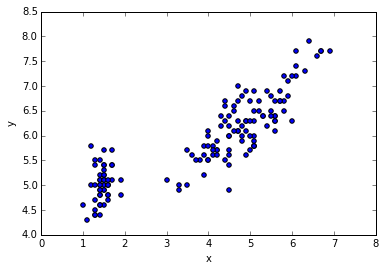

In [3]:
tmp=pd.read_csv('./iris.txt')
data=pd.DataFrame([])
data[u'x']=tmp['Petal.Length']
data[u'y']=tmp['Sepal.Length']
plt.scatter(data[u'x'],data[u'y'])
plt.xlabel("x")
plt.ylabel("y")

In [4]:
data.head()

,x,y
0,1.4,5.1
1,1.4,4.9
2,1.3,4.7
3,1.5,4.6
4,1.4,5.0


In [5]:
##　線形回帰分析
import statsmodels.formula.api as smf

eq= 'y ~ x' ##切片は自動で付加される
model = smf.ols(formula = eq, data = data)
ols=model.fit()
print ols.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     468.6
Date:                Thu, 10 Sep 2015   Prob (F-statistic):           1.04e-47
Time:                        20:17:23   Log-Likelihood:                -77.020
No. Observations:                 150   AIC:                             158.0
Df Residuals:                     148   BIC:                             164.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      4.3066      0.078     54.939      0.0

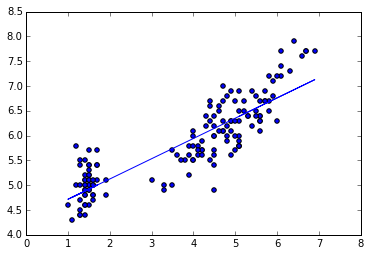

In [6]:
plt.scatter(data[u'x'],data[u'y'])
plt.plot(data[u'x'],data[u'x']*ols.params['x']+ols.params['Intercept'])

In [7]:
## 回帰係数
ols.params

Intercept    4.306603
x            0.408922
dtype: float64

In [8]:
##　二乗誤差
ols.ssr

24.525033765831751

In [9]:
## MCMC
## y=ax+b とモデル化し、aとbを推定
import pymc as pm

##　観測変数の事前分布(一様分布)を設定
a = pm.Uniform(name='a', lower=-1000, upper=1000 )
b = pm.Uniform(name='b', lower=-1000, upper=1000 )

##　観測変数の設定 ※観測されているので、分布はなんでも良い
x =  pm.Normal('x', mu=0, tau=1, value=data['x'], observed=True)
y =  pm.Normal('y', mu=a * x + b , tau=1, value=data['y'], observed=True)

##　MCMCサンプリング
M=pm.MCMC(input=[a,b,x,y])
M.sample(iter=50000,burn=10000,thin=10)

Couldn't import dot_parser, loading of dot files will not be possible.
 [-----------------100%-----------------] 50000 of 50000 complete in 13.8 sec

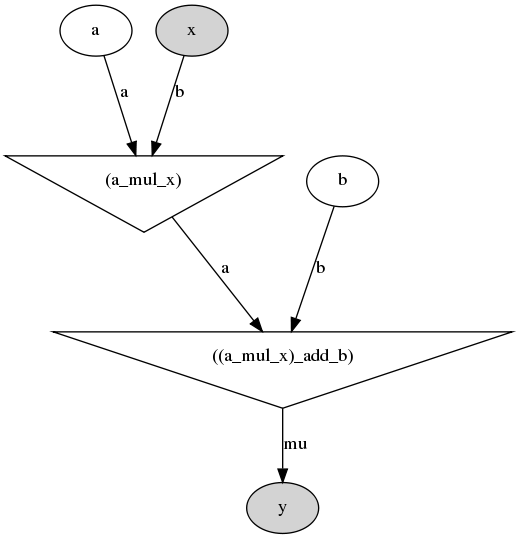

In [10]:
#グラフィカルモデル生成
from IPython.display import Image
pm.graph.dag(M,format="png")
Image("MCMC.png")

Plotting a
Plotting b


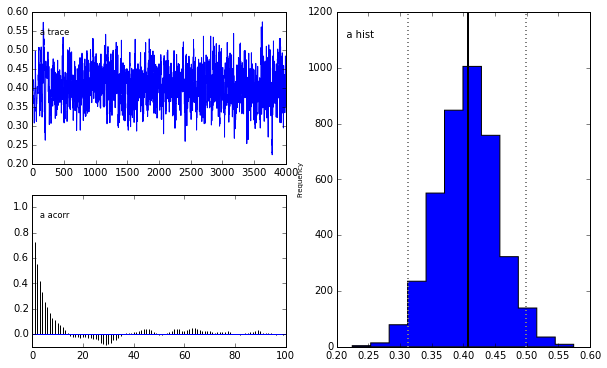

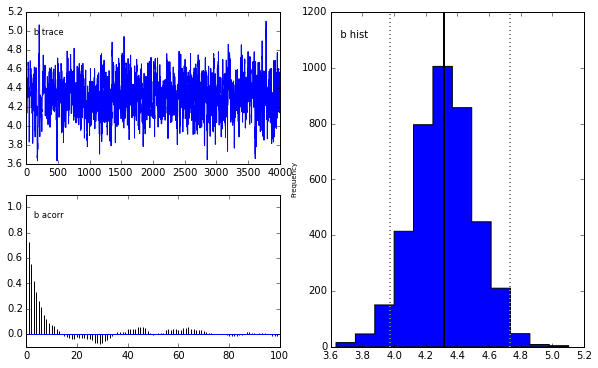

In [11]:
## MCMC 結果の表示
pm.Matplot.plot(M)

In [12]:
## MCMC 結果の表示
M.summary()


a:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[ 0.406]]       [[ 0.047]]       [[ 0.002]]       [ 0.312  0.498]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[ 0.312]]       [[ 0.374]]      [[ 0.407]]     [[ 0.437]]    [[ 0.499]]
	

b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[ 4.317]]       [[ 0.196]]       [[ 0.008]]       [ 3.974  4.733]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[ 3.923]]       [[ 4.187]]      [[ 4.318]]     [[ 4.442]]    [[ 4.706]]
	


In [13]:
##　遺伝的アルゴリズム
## y=ax+b とモデル化し、aとbを推定

## GAの設定
## 参考：https://github.com/deap/deap
##      http://3thefuture.blog.fc2.com/blog-entry-22.html
##      https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb
from deap import creator, base, tools, algorithms

#おまじない
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

def random_mod(lower,upper):
    return round( lower + random.random()*(upper-lower) ,2)

## individualの初期化のための関数
def init_individual():
    a = random_mod(0,10) ## min0,max10の一様乱数
    b = random_mod(0,10)
    return [a,b]

#individualの評価のための関数
def evalOneMax(individual): #individual(list)をうけとって、評価値である二乗誤差を返す
    a=individual[0]
    b=individual[1]
    
    datatmp=[]
    datatmp=data[['x','y']]
    datatmp['y_pred'] = list(datatmp['x'] * a + b)
    datatmp['SE']=(datatmp['y_pred']-datatmp['y'])*(datatmp['y_pred']-datatmp['y'])
    return datatmp['SE'].sum(), ## カンマ必須！

## 突然変異の設定
def mut_rand(ind, indpb): #indpd:突然変異する確率
    ind[0]=random_mod(0,10)
    ind[1]=random_mod(0,10)
    return ind,  ## カンマ必須！

#individualとpopulationの設定
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 選択、評価、交叉、突然変異の設定    
toolbox.register("evaluate", evalOneMax) #評価関数は定義した関数
toolbox.register("mate", tools.cxUniform,indpb=0.5)   #一様交叉
toolbox.register("mutate", mut_rand,indpb=0.05) #突然変異 
toolbox.register("select", tools.selTournament, tournsize=3)    #選択

gen	nevals	avg    	min    	max   
0  	1000  	80588.1	40.6554	300308
1  	375   	27479.4	40.6554	267922
2  	384   	11345.7	26.8763	277989
3  	362   	8785.42	26.8763	238080
4  	401   	7676.34	25.9897	269692
5  	373   	8548.72	25.4751	276374
6  	375   	7590.3 	24.8065	294369
7  	380   	8476.38	24.8065	263072
8  	384   	7680.62	24.8065	301289
9  	370   	8193.89	24.8065	285407
10 	380   	9606.88	24.8065	274479

Best 20 Individuals


,a,b,Square Error
0,0.39,4.35,"(24.806491000000001,)"
1,0.38,4.45,"(25.094124000000001,)"
2,0.39,4.45,"(25.475091000000003,)"
3,0.38,4.35,"(25.552924000000012,)"
4,0.39,4.30,"(25.597190999999999,)"
5,0.45,4.21,"(25.809075,)"
6,0.38,4.50,"(25.989724000000002,)"
7,0.35,4.50,"(26.254975000000005,)"
8,0.46,4.05,"(26.363436,)"
9,0.39,4.27,"(26.431611000000014,)"


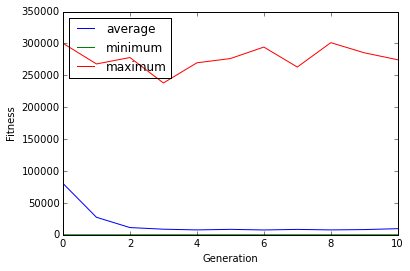

In [14]:
##遺伝的アルゴリズムの実行
num_gen     = 10  #世代数
num_pop     = 1000  #1世代あたりの個体数
p_mutation  = 0.1 #突然変異の確率
p_crossover = 0.3 #一様交叉の確率

def main():
    pop = toolbox.population(n=num_pop)
    hof = tools.HallOfFame(20)
    mstats = tools.Statistics(lambda ind: ind.fitness.values)
    mstats.register("avg", np.mean)
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    pop,logbook = algorithms.eaSimple(pop, toolbox, cxpb=p_crossover, mutpb=p_mutation, ngen=num_gen, stats=mstats, halloffame=hof, verbose=True)
    return pop, logbook, hof

pop, log, hof = main()

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")

result=pd.DataFrame([])
for i in range(0,len(hof)):
    result.loc[i,"a"]       = hof[i][0]
    result.loc[i,"b"]       = hof[i][1]
    result.loc[i,"Square Error"] = hof[i].fitness

print ""
print "Best 20 Individuals"
result